In [272]:
import re
import numpy as np
import pandas as pd
import string
import spacy
nlp = spacy.load('en')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression, RidgeCV
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [273]:
def make_df(file_name):
  df = pd.read_csv(file_name)
  return df

In [274]:
df = make_df('Shoes_Data.csv')

# Регрессия

In [275]:
cv_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,3))
tf_vectorizer = TfidfVectorizer(max_features=1000, min_df=6, max_df=0.3)

In [276]:
def text_preprocessing(sentence): #лемматизация, стопслова, знаки препинания
  lemmas = []
  sentence = nlp(sentence.lower())
  for word in sentence:
    if word.lemma_ not in stopwords.words('english'):
      lemmas.append(word.lemma_)
  lemmatized_text = ' '.join(lemmas)
  lemmatized_text = re.sub(r'\d*', '', lemmatized_text)
  lemmatized_text = lemmatized_text.encode("ascii", "ignore")
  lemmatized_text = lemmatized_text.decode()
  for punct in string.punctuation:
    lemmatized_text = lemmatized_text.replace(punct, '')
  return lemmatized_text

In [277]:
def normalization(column): #сделать от 0 до 1
  price = column.apply(lambda x: x.replace('₹', '')).apply(float)
  price = price.to_numpy()
  price = preprocessing.normalize([price])
  column = price[0].tolist()
  return column

In [278]:
 def vectorization(column, vectorizer):
   X = vectorizer.fit_transform(column)
   return X

In [279]:
def regression(vectorizer):
  X = vectorization(df['product_description'], vectorizer)
  y = df.price.values
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
  regressor = Ridge(alpha=14)
  regressor.fit(X_train, y_train)
  preds = regressor.predict(X_test)
  return X_train, X_test, y_train, y_test, preds

### Описание данных

In [280]:
df[['price', 'product_description']]

,price,product_description
0,₹279.00,Elevate your style with this classy pair of Ru...
1,₹479.00,The product will be an excellent pick for you....
2,₹430.00,Flaunt with these stylish and unique red casua...
3,₹499.00,Robbie Jones Shoes Are Designed To Keeping In ...
4,₹499.00,Sparx is a spectacular range of footwear from ...
...,...,...
1225,₹7256.00,The Nike react vision is a STORY of surreal co...
1226,₹5822.00,The B.O.G limitless is Puma's key style for th...
1227,₹5362.00,Lead the pack in New Balance’s Echolucent snea...
1228,₹7480.00,Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం మృదువ...


In [281]:
df[['price', 'product_description']].describe()

,price,product_description
count,1230,1230
unique,627,730
top,₹499.00,The product will be an excellent pick for you....
freq,31,29


In [282]:
df[['price', 'product_description']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   price                1230 non-null   object
 1   product_description  1230 non-null   object
dtypes: object(2)
memory usage: 19.3+ KB


In [283]:
import operator
words = []
for i in df['product_description'].tolist():
  for j in i.split(' '):
    if len(j)>1:
      words.append(j)
words_freq = sorted(Counter(words).items(), key=operator.itemgetter(1))[::-1][:50]
freqdf = pd.DataFrame(words_freq)

<BarContainer object of 50 artists>

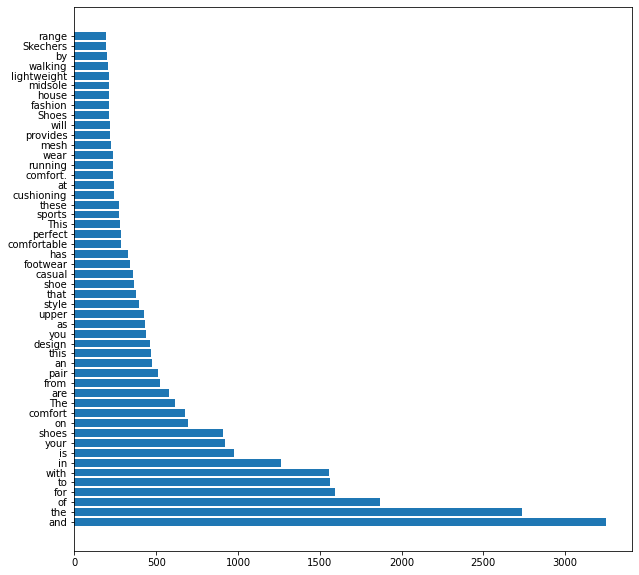

In [284]:
freqdf.columns=['word', 'freq']
plt.figure(figsize=(10, 10))
plt.barh(freqdf['word'], freqdf['freq'])

Из этих описаний можно сделать следующие выводы о данных:
1) Данные не содержат в себе нулевых значений;
2) Как у показателей цены, так и у описаний продуктов ~50% объектов являются уникальными;
3) Наиболее частотными словами, не являющимися союзами, предлогами и артиклями являются: shoes, comfort, pair, design, style, style, casual, etc (все они являются одними из базовых описаний для обуви).

In [285]:
df['product_description'] = df['product_description'].apply(text_preprocessing)

In [286]:
df['price'] = normalization(df['price'])

## Grid Search Регрессия

In [287]:
X_train, X_test, y_train, y_test = train_test_split(df['product_description'], df['price'], random_state=42)
pipeline_rcv_tf = Pipeline([('vectorizer', TfidfVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('reg', RidgeCV(gcv_mode='auto'))])
parameters_rcv_tf = {'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'reg__normalize': (True, False)}
pipeline_rcv_cv = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('reg', RidgeCV(gcv_mode='auto'))])
parameters_rcv_cv = {'vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'reg__normalize': (True, False)}
pipeline_lr_tf = Pipeline([('vectorizer', TfidfVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('reg', LinearRegression())])
parameters_lr_tf = {'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'reg__normalize': (True, False)}
pipeline_lr_cv = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('reg', LinearRegression())])
parameters_lr_cv = {'vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'reg__fit_intercept': (True, False),
               'reg__normalize': (True, False)}

In [288]:
gs_rcv = GridSearchCV(pipeline_rcv_tf, parameters_rcv_tf, n_jobs=-1, scoring = "r2")
gs_rcv = gs_rcv.fit(X_train, y_train)
print(gs_rcv.best_params_)
pred = gs_rcv.predict(X_test)
print('MAE:', mean_absolute_error(pred, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('R2:', r2_score(pred, y_test))

{'reg__normalize': False, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True}
MAE: 0.00637051533912195
RMSE: 0.010010622569258892
R2: 0.5901303610611593


In [289]:
gs_rcv = GridSearchCV(pipeline_rcv_cv, parameters_rcv_cv, n_jobs=-1, scoring = "r2")
gs_rcv = gs_rcv.fit(X_train, y_train)
print(gs_rcv.best_params_)
pred = gs_rcv.predict(X_test)
print('MAE:', mean_absolute_error(pred, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('R2:', r2_score(pred, y_test))

{'reg__normalize': False, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 3)}
MAE: 0.005590702407988227
RMSE: 0.009241281562034487
R2: 0.6384671401290278


Разница между TfIdf и CountVectorizer в случае с RidgeCV небольшая, но второй все же немного лучше.

In [290]:
gs_lr = GridSearchCV(pipeline_lr_tf, parameters_lr_tf, n_jobs=-1, scoring = "r2")
gs_lr = gs_lr.fit(X_train, y_train)
print(gs_lr.best_params_)
pred = gs_lr.predict(X_test)
print('MAE:', mean_absolute_error(pred, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('R2:', r2_score(pred, y_test))

{'reg__normalize': True, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True}
MAE: 0.010531737244419512
RMSE: 0.017182727408055213
R2: 0.31342530425849024


In [291]:
gs_lr = GridSearchCV(pipeline_lr_cv, parameters_lr_cv, n_jobs=-1, scoring = "r2")
gs_lr = gs_lr.fit(X_train, y_train)
print(gs_lr.best_params_)
pred = gs_lr.predict(X_test)
print('MAE:', mean_absolute_error(pred, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('R2:', r2_score(pred, y_test))

{'reg__fit_intercept': False, 'reg__normalize': True, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 2)}
MAE: 0.0060225180876689165
RMSE: 0.009620457386860674
R2: 0.6805218827725721


Для LinearRegression CountVectorizer работает значительно лучше, чем TfIDF.

# Вывод
Данных довольно мало для такой задачи. Стоит расширить выборку, добавить фичей. Корреляция между test и train все же не очень высокая, но ошибка довольно маленькая.

# Классификация

In [292]:
cv_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,1))
tf_vectorizer = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.4)

In [293]:
reviews = []
reviews_rating = []
classifying_data = df[['reviews', 'reviews_rating']]
for i in classifying_data['reviews'].str.split('\|\|').tolist():
  for j in i:
    reviews.append(j)
classifying_data['reviews_rating'].str.split('\|\|').tolist()
for i in classifying_data['reviews_rating'].str.split('\|\|').tolist():
  for j in i:
    if j[0]==' ':
      j = j[1:]
    reviews_rating.append(j[0])
reviews_df = pd.DataFrame({'reviews': reviews, 'reviews_rating': reviews_rating})
value_counts = reviews_df['reviews'].value_counts()
to_remove = value_counts[value_counts > 300].index
df_clean = reviews_df[~reviews_df.reviews.isin(to_remove)]
df_clean['reviews'] = df_clean['reviews'].apply(text_preprocessing)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [294]:
reviews_df[['reviews']].describe()

,reviews
count,9958
unique,5189
top,Verified Purchase
freq,647


In [295]:
reviews_df['reviews_rating'].apply(int).describe()

count    9958.000000
mean        3.772645
std         1.527403
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: reviews_rating, dtype: float64

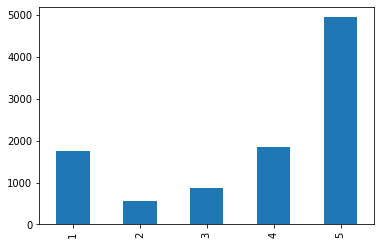

In [296]:
reviews_df['reviews_rating'].value_counts().sort_index().plot.bar()

Из этих описаний можно сделать следующие выводы о данных:
1) Данные не содержат в себе нулевых значений;
2) Средний review rating 3.8;
3) Только половина review является уникальными;
4) Частотность оценок по убыванию: 5, 4, 1, 3, 2 (обычно оставляют лио очень хорошие, либо очень плохие отзывы).

In [297]:
X = vectorization(df_clean['reviews'], cv_vectorizer)
y = df_clean.reviews_rating.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = KNeighborsClassifier().fit(X_train, y_train)
predicted = clf.predict(X_test)

In [298]:
acc = accuracy_score(predicted, y_test)
micro_f1 = f1_score(predicted, y_test, average = 'micro')
micro_p = precision_score(predicted, y_test, average = 'micro')
micro_r = recall_score(predicted, y_test, average = 'micro')
macro_f1 = f1_score(predicted, y_test, average = 'macro')
macro_p = precision_score(predicted, y_test, average = 'macro')
macro_r = recall_score(predicted, y_test, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.5697
micro F1=0.5697, micro P=0.5697, micro R=0.5697
macro F1=0.4248, macro P=0.4102, macro R=0.4635



## Grid Search Классификация

In [299]:
X_train, X_test, y_train, y_test = train_test_split(df_clean['reviews'], df_clean['reviews_rating'], random_state=42)
pipeline_kn_tf = Pipeline([('vectorizer', TfidfVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', KNeighborsClassifier())])   
parameters_kn_tf = {'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'clf__n_neighbors': [2, 3, 5, 10, 20, 30],
               'clf__weights': ['uniform', 'distance']}
pipeline_kn_cv = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', KNeighborsClassifier())])   
parameters_kn_cv = {'vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'clf__n_neighbors': [2, 3, 5, 10, 20, 30],
               'clf__weights': ['uniform', 'distance']}
pipeline_nb_tf = Pipeline([('vectorizer', TfidfVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', MultinomialNB())])
parameters_nb_tf = {'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'clf__alpha': [0.1, 0.3, 0.5],
               'clf__fit_prior': [True, False],
               'clf__class_prior': [None, [.1,.9],[.2, .8]]}
pipeline_nb_cv = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', MultinomialNB())])
parameters_nb_cv = {'vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'clf__alpha': [0.1, 0.3, 0.5],
               'clf__fit_prior': [True, False],
               'clf__class_prior': [None, [.1,.9],[.2, .8]]}

Используется F1-мера, так как классификация является многоклассовой, классы неравномерные.

In [310]:
gs_kn_tf = GridSearchCV(pipeline_kn_tf, parameters_kn_tf, n_jobs=-1, scoring = "f1_weighted")
gs_kn_tf = gs_kn_tf.fit(X_train, y_train)
print(gs_kn_tf.best_params_)
pred = gs_kn_tf.predict(X_test)
print('F1:', f1_score(pred, y_test, average='weighted'))

{'clf__n_neighbors': 5, 'clf__weights': 'distance', 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': False}
F1: 0.5963433369085551


In [311]:
gs_kn_cv = GridSearchCV(pipeline_kn_cv, parameters_kn_cv, n_jobs=-1, scoring = "f1_weighted")
gs_kn_cv = gs_kn_cv.fit(X_train, y_train)
print(gs_kn_cv.best_params_)
pred = gs_kn_cv.predict(X_test)
print('F1:', f1_score(pred, y_test, average='weighted'))

{'clf__n_neighbors': 5, 'clf__weights': 'distance', 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 1)}
F1: 0.5955931323939192


In [312]:
gs_nb_tf = GridSearchCV(pipeline_nb_tf, parameters_nb_tf, n_jobs=-1, scoring = "f1_weighted")
gs_nb_tf = gs_nb_tf.fit(X_train, y_train)
print(gs_nb_tf.best_params_)
pred = gs_nb_tf.predict(X_test)
print('F1:', f1_score(pred, y_test, average='weighted'))

{'clf__alpha': 0.1, 'clf__class_prior': None, 'clf__fit_prior': True, 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': False}
F1: 0.666506817639685


In [313]:
gs_nb_cv = GridSearchCV(pipeline_nb_cv, parameters_nb_cv, n_jobs=-1, scoring = "f1_weighted")
gs_nb_cv = gs_nb_cv.fit(X_train, y_train)
print(gs_nb_cv.best_params_)
pred = gs_nb_cv.predict(X_test)
print('F1:', f1_score(pred, y_test, average='weighted'))

{'clf__alpha': 0.1, 'clf__class_prior': None, 'clf__fit_prior': True, 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 3)}
F1: 0.6803541243042849


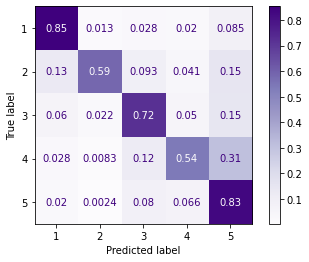

In [306]:
plot_confusion_matrix(gs_kn_tf, df_clean['reviews'], df_clean['reviews_rating'], normalize='true', cmap='Purples')

Хорошо определяются 1, 3 и 5. Хуже 2 и 4. Часто определяет 4 как 5.

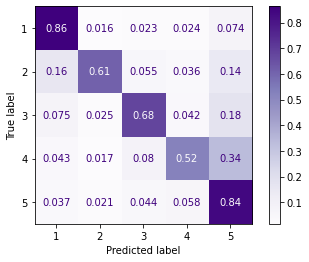

In [307]:
plot_confusion_matrix(gs_kn_cv, df_clean['reviews'], df_clean['reviews_rating'], normalize='true', cmap='Purples')

Работает совсем немного лучше, но в целом почти так же.

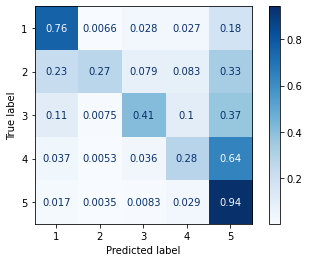

In [308]:
plot_confusion_matrix(gs_nb_tf, df_clean['reviews'], df_clean['reviews_rating'], normalize='true', cmap='Blues')

По графику видно, что очень часто 2, 3 (особенно) и 4 отправляются в 5. При этом 5 и 1 предсказываются хорошо. Еще часто 2 определяет как 1.

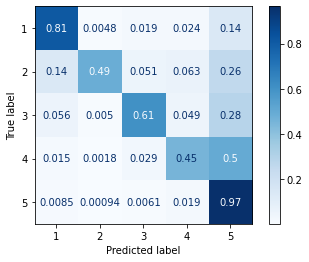

In [309]:
plot_confusion_matrix(gs_nb_cv, df_clean['reviews'], df_clean['reviews_rating'], normalize='true', cmap='Blues')

Работает заметно лучше TfIdf. Намного лучше стал определять 2, 3 и 4. Реже путает с 5.

## Вывод
В дальнейшем нужно расширить выборку, так как данных очень мало, добавить фичей, сбалансировать выборку. Можно еще смотреть по маркам (title), думаю это сильно улучшит модель, так как от марки часто зависит ценовой диапазон.